In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import subprocess
import pyproj

In [11]:
from tectosaur.mesh.mesh_gen import make_sphere
from tectosaur.mesh.refine import selective_refine
from tectosaur.util.geometry import unscaled_normals

In [12]:
r = 6371000
orig_surf = make_sphere([0,0,0], r, 1)

In [13]:
focal_point = [r, 0, 0]
threshold = 1e4
iters = 0
max_iters = 100
inner_ring = 100000.0
inner_ring_area = 100000000.0
m = orig_surf
while iters < max_iters:
    iters += 1
    tri_pts = m[0][m[1]]
    tri_centroids = np.mean(tri_pts, axis = 1)
    dist = np.linalg.norm(tri_centroids - focal_point, axis = 1)
    area = np.linalg.norm(unscaled_normals(tri_pts), axis = 1) / 2.0
    print(np.max(area / dist))
    refine = area / dist > threshold
    refine = np.where(dist < inner_ring, area > inner_ring_area, refine)
    if np.all(refine == False):
        break
    new_mesh = selective_refine(m, refine)
    new_pts = r * (new_mesh[0] / np.linalg.norm(new_mesh[0], axis = 1)[:, np.newaxis])
    new_tris = scipy.spatial.ConvexHull(new_pts).simplices
    m = (new_pts, new_tris)
    print('at iter = ' + str(iters) + ' mesh has ' + str(m[0].shape[0]) + ' pts and ' + str(m[1].shape[0]) + ' tris.')

4778250.0
at iter = 1 mesh has 66 pts and 128 tris.
2585970.26552
at iter = 2 mesh has 258 pts and 512 tris.
1318316.20906
at iter = 3 mesh has 1026 pts and 2048 tris.
662347.488726
at iter = 4 mesh has 4098 pts and 8192 tris.
331573.13873
at iter = 5 mesh has 7210 pts and 14416 tris.
165836.516223
at iter = 6 mesh has 7850 pts and 15696 tris.
82924.502174
at iter = 7 mesh has 8006 pts and 16008 tris.
41463.0316168
at iter = 8 mesh has 8074 pts and 16144 tris.
20731.6133753
at iter = 9 mesh has 8310 pts and 16616 tris.
10365.8188836


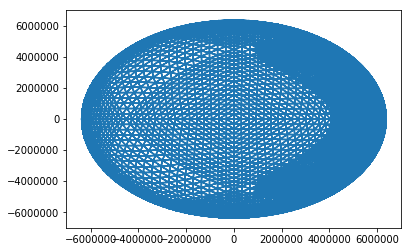

In [14]:
plt.figure()
plt.triplot(m[0][:,0], m[0][:,1], m[1])
plt.show()

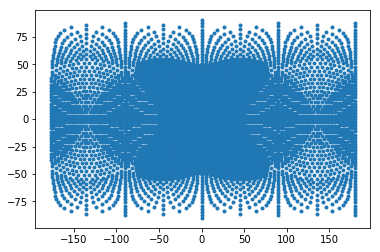

In [15]:
x = m[0][:,0]
y = m[0][:,1]
z = m[0][:,2]
phi = np.arccos(z / r)
latitude = np.rad2deg(phi) - 90
theta = np.arctan2(y, x)
longitude = np.rad2deg(theta)
plt.plot(longitude, latitude, '.')
plt.show()

In [16]:
wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
proj = pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs')
x_new,y_new,z_new = pyproj.transform(wgs84, proj, longitude, latitude, 0 * longitude)
projected_pts = np.vstack((x_new,y_new,z_new)).T
m_wgs84 = (projected_pts, m[1])

In [17]:
np.save('refined_sphere_mesh.npy', m_wgs84)

In [1]:
import numpy as np
from tectosaur_topo import solve_topo
from tectosaur.mesh.mesh_gen import make_rect
from cigcdm.slip_vectors import get_slip_vectors
import pyproj

In [2]:
surf = np.load('refined_sphere_mesh.npy')

In [14]:
fault_top_depth = 4 * 1000
fault_bottom_depth = 15 * 1000
fault_length = 1.0
fault_el_size = 2000.0
m_per_deg = 111000
fault_nx = int(fault_length * m_per_deg / fault_el_size)
fault_ny = int((fault_bottom_depth - fault_top_depth) / fault_el_size)

corners = [
    [fault_length / 2, 0, -fault_top_depth],
    [-fault_length / 2, 0, -fault_top_depth],
    [-fault_length / 2, 0, -fault_bottom_depth],
    [fault_length / 2, 0, -fault_bottom_depth]
]
fault = make_rect(fault_nx, fault_ny, corners)

In [15]:
wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
proj = pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs')
x_new,y_new,z_new = pyproj.transform(wgs84, proj, fault[0][:,0], fault[0][:,1], fault[0][:,2])
projected_pts = np.vstack((x_new,y_new,z_new)).T
fault_projected = (projected_pts, fault[1])

<IPython.core.display.Javascript object>


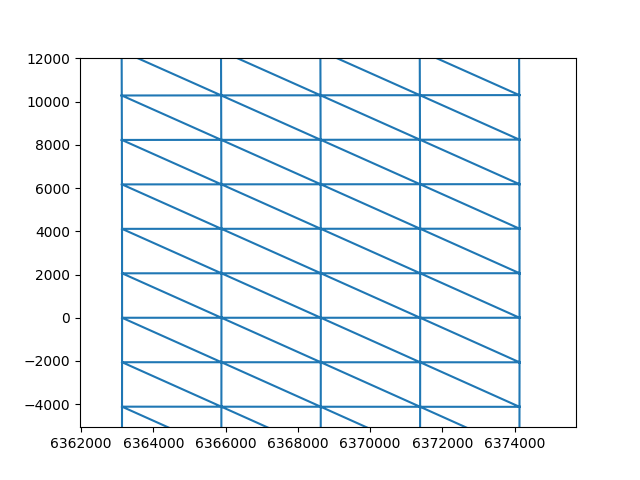

In [20]:
%matplotlib notebook
plt.triplot(fault_projected[0][:,0], fault_projected[0][:,1], fault_projected[1])
plt.show()

In [21]:
v1,v2 = get_slip_vectors(projected_pts[fault[1][0,:]])
# print(v1,v2)
fault_slip = np.array([[0, 1, 0]] * 3 * fault[1].shape[0]).flatten()
#project fault and fault slip

In [22]:
surf_pts, surf_disp = solve_topo(surf, fault_projected, fault_slip, 1.0, 0.25)
np.save('data/sphere_ss.npy', (surf_pts, surf_disp))

2017-09-26 00:00:51,605 - tectosaur.util.gpu - DEBUG - start compiling nearfield/nearfield.cl
2017-09-26 00:00:52,721 - tectosaur.util.cuda - DEBUG - Initialized CUDA on gpu: 0
2017-09-26 00:00:53,340 - tectosaur.util.gpu - DEBUG - compile took 1.7347476482391357
2017-09-26 00:00:53,355 - tectosaur.nearfield.nearfield_op - DEBUG -     setup pairs integrator took 1.7499408721923828
2017-09-26 00:00:53,363 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- load table took 0.006168842315673828
2017-09-26 00:00:53,436 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- get pts took 0.07184219360351562
2017-09-26 00:00:53,437 - tectosaur.util.gpu - DEBUG - start compiling nearfield/table_lookup.cl
2017-09-26 00:00:53,718 - tectosaur.util.gpu - DEBUG - compile took 0.2806699275970459
2017-09-26 00:00:53,743 - tectosaur.nearfield.table_lookup - DEBUG - coincident -- interpolate took 0.30613160133361816
2017-09-26 00:00:53,784 - tectosaur.nearfield.table_lookup - DEBUG - coincid

2017-09-26 00:01:01,561 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010941028594970703
2017-09-26 00:01:01,562 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05419135093688965
2017-09-26 00:01:01,564 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001041412353515625
2017-09-26 00:01:01,565 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05971217155456543
2017-09-26 00:01:01,567 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3319723606109619
2017-09-26 00:01:01,568 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041103363037109375
2017-09-26 00:01:01,576 - tectosaur_topo.solve - DEBUG - iteration # 3
2017-09-26 00:01:01,577 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0004603862762451172
2017-09-26 00:01:01,856 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.27796053886413574
2017-09-26 00:01:01,860 - tect

2017-09-26 00:01:03,582 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2687857151031494
2017-09-26 00:01:03,585 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001619577407836914
2017-09-26 00:01:03,587 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009951591491699219
2017-09-26 00:01:03,636 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04782676696777344
2017-09-26 00:01:03,637 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.049191951751708984
2017-09-26 00:01:03,639 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0012481212615966797
2017-09-26 00:01:03,640 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05445289611816406
2017-09-26 00:01:03,642 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011584758758544922
2017-09-26 00:01:03,643 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.06007075309753418
2017-0

2017-09-26 00:01:05,382 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010366439819335938
2017-09-26 00:01:05,383 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05969715118408203
2017-09-26 00:01:05,385 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3318288326263428
2017-09-26 00:01:05,386 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004036426544189453
2017-09-26 00:01:05,387 - tectosaur_topo.solve - DEBUG - residual: 0.6076281845270091
2017-09-26 00:01:05,389 - tectosaur_topo.solve - DEBUG - iteration # 14
2017-09-26 00:01:05,390 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002894401550292969
2017-09-26 00:01:05,659 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2681558132171631
2017-09-26 00:01:05,662 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016236305236816406
2017-09-26 00:01:05,664 - tectosaur.ops.sparse

2017-09-26 00:01:07,423 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2772996425628662
2017-09-26 00:01:07,426 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016078948974609375
2017-09-26 00:01:07,428 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009989738464355469
2017-09-26 00:01:07,477 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04781842231750488
2017-09-26 00:01:07,478 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04916548728942871
2017-09-26 00:01:07,481 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011513233184814453
2017-09-26 00:01:07,481 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0542597770690918
2017-09-26 00:01:07,484 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011577606201171875
2017-09-26 00:01:07,484 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.059905290603637695
2017-0

2017-09-26 00:01:09,237 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010411739349365234
2017-09-26 00:01:09,238 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.059641122817993164
2017-09-26 00:01:09,240 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3319966793060303
2017-09-26 00:01:09,241 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040221214294433594
2017-09-26 00:01:09,242 - tectosaur_topo.solve - DEBUG - residual: 0.5053878109408685
2017-09-26 00:01:09,244 - tectosaur_topo.solve - DEBUG - iteration # 25
2017-09-26 00:01:09,245 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002918243408203125
2017-09-26 00:01:09,514 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2683224678039551
2017-09-26 00:01:09,518 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016117095947265625
2017-09-26 00:01:09,520 - tectosaur.ops.spar

2017-09-26 00:01:11,204 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2684168815612793
2017-09-26 00:01:11,207 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001613616943359375
2017-09-26 00:01:11,209 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009984970092773438
2017-09-26 00:01:11,258 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04781532287597656
2017-09-26 00:01:11,259 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04908299446105957
2017-09-26 00:01:11,261 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011718273162841797
2017-09-26 00:01:11,262 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05408358573913574
2017-09-26 00:01:11,264 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010323524475097656
2017-09-26 00:01:11,265 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05943417549133301
2017-09

2017-09-26 00:01:12,985 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00103759765625
2017-09-26 00:01:12,986 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.059671640396118164
2017-09-26 00:01:12,988 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3317711353302002
2017-09-26 00:01:12,990 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003993511199951172
2017-09-26 00:01:12,991 - tectosaur_topo.solve - DEBUG - residual: 0.32343108492490213
2017-09-26 00:01:12,993 - tectosaur_topo.solve - DEBUG - iteration # 36
2017-09-26 00:01:12,994 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003142356872558594
2017-09-26 00:01:13,264 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.26840853691101074
2017-09-26 00:01:13,267 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016129016876220703
2017-09-26 00:01:13,269 - tectosaur.ops.sparse_i

2017-09-26 00:01:14,956 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.26869964599609375
2017-09-26 00:01:14,959 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016193389892578125
2017-09-26 00:01:14,961 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009963512420654297
2017-09-26 00:01:15,010 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.047826528549194336
2017-09-26 00:01:15,011 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.049167633056640625
2017-09-26 00:01:15,013 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010952949523925781
2017-09-26 00:01:15,014 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.054175376892089844
2017-09-26 00:01:15,016 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010328292846679688
2017-09-26 00:01:15,017 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05968117713928223
20

2017-09-26 00:01:16,756 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010352134704589844
2017-09-26 00:01:16,757 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05968594551086426
2017-09-26 00:01:16,759 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.33150148391723633
2017-09-26 00:01:16,760 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00040221214294433594
2017-09-26 00:01:16,761 - tectosaur_topo.solve - DEBUG - residual: 0.18316388823633895
2017-09-26 00:01:16,764 - tectosaur_topo.solve - DEBUG - iteration # 47
2017-09-26 00:01:16,765 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00029158592224121094
2017-09-26 00:01:17,035 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2688755989074707
2017-09-26 00:01:17,038 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016124248504638672
2017-09-26 00:01:17,040 - tectosaur.ops.sp

2017-09-26 00:01:18,731 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2683398723602295
2017-09-26 00:01:18,734 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016083717346191406
2017-09-26 00:01:18,736 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010006427764892578
2017-09-26 00:01:18,785 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04781842231750488
2017-09-26 00:01:18,786 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04915809631347656
2017-09-26 00:01:18,788 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010972023010253906
2017-09-26 00:01:18,789 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.054197072982788086
2017-09-26 00:01:18,791 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010387897491455078
2017-09-26 00:01:18,792 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.059677839279174805
2017

2017-09-26 00:01:20,491 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.00103759765625
2017-09-26 00:01:20,491 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05971646308898926
2017-09-26 00:01:20,494 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.33229827880859375
2017-09-26 00:01:20,495 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0003979206085205078
2017-09-26 00:01:20,496 - tectosaur_topo.solve - DEBUG - residual: 0.11511635462018348
2017-09-26 00:01:20,499 - tectosaur_topo.solve - DEBUG - iteration # 58
2017-09-26 00:01:20,500 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.00029015541076660156
2017-09-26 00:01:20,770 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.26912569999694824
2017-09-26 00:01:20,773 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016148090362548828
2017-09-26 00:01:20,775 - tectosaur.ops.sparse_

2017-09-26 00:01:22,467 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2687866687774658
2017-09-26 00:01:22,471 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016429424285888672
2017-09-26 00:01:22,473 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0009975433349609375
2017-09-26 00:01:22,522 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04781842231750488
2017-09-26 00:01:22,523 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04921555519104004
2017-09-26 00:01:22,525 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011415481567382812
2017-09-26 00:01:22,526 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.054167747497558594
2017-09-26 00:01:22,528 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010678768157958984
2017-09-26 00:01:22,529 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05963611602783203
2017-

2017-09-26 00:01:24,258 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010578632354736328
2017-09-26 00:01:24,259 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05990910530090332
2017-09-26 00:01:24,261 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3617725372314453
2017-09-26 00:01:24,262 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00039315223693847656
2017-09-26 00:01:24,263 - tectosaur_topo.solve - DEBUG - residual: 0.08106659281119541
2017-09-26 00:01:24,267 - tectosaur_topo.solve - DEBUG - iteration # 69
2017-09-26 00:01:24,268 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003123283386230469
2017-09-26 00:01:24,537 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2682607173919678
2017-09-26 00:01:24,540 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016124248504638672
2017-09-26 00:01:24,542 - tectosaur.ops.spar

2017-09-26 00:01:26,236 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.26807713508605957
2017-09-26 00:01:26,239 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016126632690429688
2017-09-26 00:01:26,241 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010018348693847656
2017-09-26 00:01:26,290 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04784655570983887
2017-09-26 00:01:26,291 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04916095733642578
2017-09-26 00:01:26,293 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010957717895507812
2017-09-26 00:01:26,294 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05413198471069336
2017-09-26 00:01:26,296 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010330677032470703
2017-09-26 00:01:26,297 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05962109565734863
2017-

2017-09-26 00:01:27,997 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010364055633544922
2017-09-26 00:01:27,998 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05966544151306152
2017-09-26 00:01:28,000 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.33226704597473145
2017-09-26 00:01:28,001 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00041103363037109375
2017-09-26 00:01:28,002 - tectosaur_topo.solve - DEBUG - residual: 0.06172378861607453
2017-09-26 00:01:28,006 - tectosaur_topo.solve - DEBUG - iteration # 80
2017-09-26 00:01:28,008 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0002925395965576172
2017-09-26 00:01:28,277 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2687809467315674
2017-09-26 00:01:28,280 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.001613616943359375
2017-09-26 00:01:28,283 - tectosaur.ops.spar

2017-09-26 00:01:30,010 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2982761859893799
2017-09-26 00:01:30,014 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0019092559814453125
2017-09-26 00:01:30,016 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010437965393066406
2017-09-26 00:01:30,065 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04782462120056152
2017-09-26 00:01:30,066 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04914736747741699
2017-09-26 00:01:30,068 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011310577392578125
2017-09-26 00:01:30,069 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05438709259033203
2017-09-26 00:01:30,071 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011641979217529297
2017-09-26 00:01:30,072 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.06042170524597168
2017-0

2017-09-26 00:01:31,818 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0011532306671142578
2017-09-26 00:01:31,819 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.06029677391052246
2017-09-26 00:01:31,822 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.36281704902648926
2017-09-26 00:01:31,823 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0005154609680175781
2017-09-26 00:01:31,824 - tectosaur_topo.solve - DEBUG - residual: 0.04911342248726138
2017-09-26 00:01:31,829 - tectosaur_topo.solve - DEBUG - iteration # 91
2017-09-26 00:01:31,830 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003662109375
2017-09-26 00:01:32,129 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2981235980987549
2017-09-26 00:01:32,132 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0019304752349853516
2017-09-26 00:01:32,134 - tectosaur.ops.sparse_int

2017-09-26 00:01:33,840 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0016045570373535156
2017-09-26 00:01:33,842 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010058879852294922
2017-09-26 00:01:33,891 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.047804832458496094
2017-09-26 00:01:33,892 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.04914689064025879
2017-09-26 00:01:33,894 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0011172294616699219
2017-09-26 00:01:33,895 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.0542294979095459
2017-09-26 00:01:33,897 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.001028299331665039
2017-09-26 00:01:33,898 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05967831611633301
2017-09-26 00:01:33,900 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3315126895904541
2017-0

2017-09-26 00:01:35,603 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.059992074966430664
2017-09-26 00:01:35,605 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3324286937713623
2017-09-26 00:01:35,606 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.0004987716674804688
2017-09-26 00:01:35,607 - tectosaur_topo.solve - DEBUG - residual: 0.040066790387243194
2017-09-26 00:01:35,612 - tectosaur_topo.solve - DEBUG - iteration # 102
2017-09-26 00:01:35,614 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003733634948730469
2017-09-26 00:01:35,913 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2980988025665283
2017-09-26 00:01:35,916 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0019235610961914062
2017-09-26 00:01:35,918 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0010213851928710938
2017-09-26 00:01:35,967 - tectosaur.fmm.evaluator - DE

2017-09-26 00:01:37,625 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.000993967056274414
2017-09-26 00:01:37,674 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.04783010482788086
2017-09-26 00:01:37,675 - tectosaur.ops.sparse_integral_op - DEBUG - fmm eval took 0.049164772033691406
2017-09-26 00:01:37,677 - tectosaur.ops.sparse_integral_op - DEBUG - to output space took 0.0010919570922851562
2017-09-26 00:01:37,678 - tectosaur.ops.sparse_integral_op - DEBUG - farfield_op.dot took 0.05419301986694336
2017-09-26 00:01:37,680 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.T.dot took 0.0010387897491455078
2017-09-26 00:01:37,681 - tectosaur.ops.sparse_integral_op - DEBUG - farfield dot took 0.05966687202453613
2017-09-26 00:01:37,683 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.3316476345062256
2017-09-26 00:01:37,684 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00039768218994140625
201

2017-09-26 00:01:39,393 - tectosaur_topo.solve - DEBUG - integral operator multiply took 0.33191704750061035
2017-09-26 00:01:39,394 - tectosaur_topo.solve - DEBUG - constraint matrix transpose multiply took 0.00039649009704589844
2017-09-26 00:01:39,395 - tectosaur_topo.solve - DEBUG - residual: 0.030792404486244634
2017-09-26 00:01:39,400 - tectosaur_topo.solve - DEBUG - iteration # 113
2017-09-26 00:01:39,402 - tectosaur_topo.solve - DEBUG - constraint matrix multiply took 0.0003056526184082031
2017-09-26 00:01:39,671 - tectosaur.ops.sparse_integral_op - DEBUG - nearfield dot took 0.2682616710662842
2017-09-26 00:01:39,674 - tectosaur.ops.sparse_integral_op - DEBUG - interp_galerkin_mat.dot took 0.0019328594207763672
2017-09-26 00:01:39,676 - tectosaur.ops.sparse_integral_op - DEBUG - to tree space took 0.0011150836944580078
2017-09-26 00:01:39,726 - tectosaur.fmm.evaluator - DEBUG - fmm data returned took 0.047855377197265625
2017-09-26 00:01:39,727 - tectosaur.ops.sparse_integral_

KeyboardInterrupt: 

In [ ]:
# I think a good next step might be to use a dense matrix/direct solver to check
# that the matrix is well-conditioned. I suspect the problem is in the constraints
# but I'm not so sure where exactly...